In [3]:
import pandas as pd
import numpy as np
import argparse
import glob
import joblib
# import os

# from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, train_test_split

CALC_PATHS = '/home/nfs/jludwiczak/af2_cc/af2_multimer/calc'


def get_x(id_: int, rank: int, model: str = "af2", 
          use_pairwise: bool = True):

    single_repr_fns = sorted(glob.glob(f"{CALC_PATHS}/{id_}/*_single_repr_rank_00*"))
    pair_repr_fns = sorted(glob.glob(f"{CALC_PATHS}{id_}/*_pair_repr_rank_00*"))

    mat = np.load(single_repr_fns[rank]).mean(axis=0)
    if use_pairwise:
        mat = np.hstack((mat, np.load(pair_repr_fns[rank]).mean(axis=0).mean(axis=0)))
    return mat

def get_af2_emb(id_: int, model_id: int, use_pairwise: bool):

    single_repr_fns = sorted(glob.glob(f"{CALC_PATHS}/{id_}/*_single_repr_rank_*_model_{model_id+1}_*"))
    pair_repr_fns = sorted(glob.glob(f"{CALC_PATHS}/{id_}/*_pair_repr_rank_*_model_{model_id+1}_*"))


    mat = np.load(single_repr_fns[0]).mean(axis=0)

    if use_pairwise:
        mat = np.hstack((mat, np.load(pair_repr_fns[0]).mean(axis=0).mean(axis=0)))

    return mat



In [ ]:
df = pd.read_csv("tests/set4_homooligomers.csv", sep="\t")
df = df.drop_duplicates(subset="full_sequence", keep="first")
df.parallel.unique()

In [ ]:
from sklearn.model_selection import KFold, train_test_split

from itertools import product

def train(c=10, balanced=0, dual=1, ensemble_size=1, use_pairwise=True, use_scaler=True):

    df = pd.read_csv("tests/set4_homooligomers.csv", sep="\t")
    df = df.drop_duplicates(subset="full_sequence", keep="first")
    results = np.zeros((ensemble_size, 5, len(df), 2))
    model = {}
    probabilities = []
    for j in range(0, ensemble_size):
        for i in range(0, 5): # 5 since we have 5 AF2 models

            X = np.asarray([get_af2_emb(id_, model_id=i, use_pairwise=use_pairwise) for id_ in df.index])
            y = df['parallel'].values
            cv = KFold(n_splits=5, shuffle=True)

            for k, (tr_idx, te_idx) in enumerate(cv.split(X, y)):

                X_tr, X_te = X[tr_idx], X[te_idx]
                y_tr, y_te = y[tr_idx], y[te_idx]

                if use_scaler == 1:
                    sc = StandardScaler()
                    X_tr = sc.fit_transform(X_tr)
                    X_te = sc.transform(X_te)
                    model[f"scaler_{j}_{i}_{k}"] = sc
                clf = LogisticRegression(C=c, max_iter=1000, solver='liblinear',
                                         dual = False if dual == 0 else True, 
                                         class_weight = 'balanced' if balanced == 1 else None) 
                clf.fit(X_tr, y_tr)
                results[j, i, te_idx] = clf.predict_proba(X_te)
                model[f"clf_{j}_{i}_{k}"] = clf

    y_pred_bin = results.mean(axis=0).mean(axis=0).argmax(axis=1)
    results_ = {}
    results_["accuracy"] = accuracy_score(y, y_pred_bin)
    results_["f1"] = f1_score(y, y_pred_bin, average='macro')

    df["y_pred"] = y_pred_bin
    # df["prob_dimer"] = results.mean(axis=0).mean(axis=0)[:, 0]
    # df["prob_trimer"] = results.mean(axis=0).mean(axis=0)[:, 1]
    # df["prob_tetramer"] = results.mean(axis=0).mean(axis=0)[:, 2]

    return results_, model, df

# c = [1,5,10,15,20]
# balanced = [0,1]
# dual = [0,1]
# ensemble_size = [1,2,3,4,5]
# use_pairwise = [True, False]

# results = []
# for c_, balanced_, dual_, ensemble_size_, use_pairwise_ in product(c, balanced, dual, ensemble_size, use_pairwise):
#     results_, model, df = train(c=c_, balanced=balanced_, dual=dual_, ensemble_size=ensemble_size_, use_pairwise=use_pairwise_)
#     print(results_["accuracy"], results_["f1"])
#     results.append((c_, balanced_, dual_, ensemble_size_, use_pairwise_, results_["accuracy"], results_["f1"]))



In [ ]:


def train(c=10, balanced=0, dual=1, ensemble_size=1, use_pairwise=True, use_scaler=True):
    df = pd.read_csv("tests/set4_homooligomers.csv", sep="\t")
    df = df.drop_duplicates(subset="full_sequence", keep="first")
    
    # Initialize results arrays for both target variables
    results_parallel = np.zeros((ensemble_size, 5, len(df), 2))
    results_oligo = np.zeros((ensemble_size, 5, len(df), 3))
    
    model = {}
    for j in range(0, ensemble_size):
        for i in range(0, 5): # 5 since we have 5 AF2 models
            X = np.asarray([get_af2_emb(id_, model_id=i, use_pairwise=use_pairwise) for id_ in df.index])
            
            # Combine target variables into a single array
            y_parallel = df['parallel'].values
            le = LabelEncoder()
            df['oligo_state'] = le.fit_transform(df['chains'])
            y_state = df['oligo_state'].values
            y = np.column_stack((y_parallel, y_state))
            
            cv = KFold(n_splits=5, shuffle=True)
            for k, (tr_idx, te_idx) in enumerate(cv.split(X, y)):
                X_tr, X_te = X[tr_idx], X[te_idx]
                y_tr, y_te = y[tr_idx], y[te_idx]

                if use_scaler == 1:
                    sc = StandardScaler()
                    X_tr = sc.fit_transform(X_tr)
                    X_te = sc.transform(X_te)
                    model[f"scaler_{j}_{i}_{k}"] = sc
                
                # Train and evaluate multi-output model
                clf = MultiOutputClassifier(LogisticRegression(C=c, max_iter=2000, solver='liblinear',
                                         dual=False if dual == 0 else True,
                                         class_weight='balanced' if balanced == 1 else None))
                clf.fit(X_tr, y_tr)
                proba_parallel, proba_chains = clf.predict_proba(X_te)
                results_parallel[j, i, te_idx] = proba_parallel
                results_oligo[j, i, te_idx] = proba_chains
                model[f"clf_{j}_{i}_{k}"] = clf

    # Calculate average probabilities and predicted classes for both target variables
    avg_proba_parallel = results_parallel.mean(axis=0).mean(axis=0)
    avg_proba_state = results_oligo.mean(axis=0).mean(axis=0)
    
    y_pred_bin_parallel = avg_proba_parallel.argmax(axis=1)
    y_pred_bin_state = avg_proba_state.argmax(axis=1)
    
    results_ = {}
    
    # Calculate accuracy and F1 score for parallel target variable
    results_["accuracy_parallel"] = accuracy_score(y_parallel, y_pred_bin_parallel)
    results_["f1_parallel"] = f1_score(y_parallel, y_pred_bin_parallel, average='macro')
    
    # Calculate accuracy and F1 score for chains target variable
    results_["accuracy_oligo_state"] = accuracy_score(y_state, y_pred_bin_state)
    results_["f1_oligo_state"] = f1_score(y_state, y_pred_bin_state, average='macro')

    df["y_pred_parallel"] = y_pred_bin_parallel
    df["y_pred_chains"] = y_pred_bin_state
    df["prob_dimer"] = avg_proba_state[:,0]
    df["prob_trimer"] = avg_proba_state[:,1]
    df["prob_tetramer"] = avg_proba_state[:, 2]
    df["prob_parallel"] = avg_proba_parallel[:, 1]
    df["prob_antiparallel"] = avg_proba_parallel[:, 0]
    df.to_csv('model_results.csv')

    return results_, model, df  


train()


In [ ]:
df = pd.read_csv("model/results.csv")
df

In [ ]:
from sklearn.metrics import confusion_matrix
import  seaborn as sns
confusion_matrix(df.parallel, df.y_pred_parallel)
# sns.heatmap(confusion_matrix(df.parallel, df.y_pred_parallel), annot=True, cmap="Blues", fmt="d")
confusion_matrix(df.oligo_state, df.y_pred_chains)
sns.heatmap(confusion_matrix(df.oligo_state, df.y_pred_chains), annot=True, cmap="Blues", fmt="d")

In [ ]:
df = pd.read_csv("new_model_results.csv")
le = LabelEncoder()
df['parallel_code'] = le.fit_transform(df['parallel'])
df[['pdb','parallel_code','parallel']].loc[df.pdb == '4dzo'].head(10)

In [6]:
import glob
from src.predictor import predict_oligo_state_and_topology
import pandas as pd

# path = glob.glob('tests/data/*/')
# df = pd.DataFrame()
# for f in path:
#     df = pd.concat([df, predict_oligo_state_and_topology(f, use_pairwise=True)], axis=0)
# df.to_csv('tests/test_df.csv', index=False)

In [ ]:
tdf  = pd.DataFrame()
for f in path:
    tdf = pd.concat([tdf, predict_oligo_state_and_topology(f, use_pairwise=True)], axis=0)
tdf

In [ ]:
df  = pd.read_csv('tests/test_df.csv').reset_index(drop=True)
df

In [10]:
from src.predictor import predict_oligo_state_and_topology
df = pd.DataFrame()

test_cases = [x for x in glob.glob('/home/nfs/rmadaj/IDUB/dc2_oligo/tmp/*/') if 'env' not in x]
pdb_annot = [x.split('/')[-2].split('_')[0] for x in glob.glob('tmp/*/*_env/')]
test_cases
for pdb, test_case in zip(pdb_annot,test_cases):
    try:
        tdf = predict_oligo_state_and_topology(test_case, use_pairwise=True)
        tdf['pdb'] = pdb
        df = pd.concat([df, tdf], axis=0)
    except:
        print(test_case, pdb)
        pass
df  = df.sort_values(by=['pdb'])
df

Predicted oligomer state: Trimer (1) with probability           0.90813 +/- 0.16285           
Predicted topology: Parallel (1) with probability             0.82573 +/- 0.3406
Predicted oligomer state: Trimer (1) with probability           0.83032 +/- 0.19094           
Predicted topology: Parallel (1) with probability             0.80418 +/- 0.39164
Predicted oligomer state: Dimer (0) with probability           0.73622 +/- 0.21698           
Predicted topology: Parallel (1) with probability             0.82907 +/- 0.16308
Predicted oligomer state: Dimer (0) with probability           0.49676 +/- 0.27357           
Predicted topology: Parallel (1) with probability             0.74375 +/- 0.36426
Predicted oligomer state: Dimer (0) with probability           0.86341 +/- 0.18874           
Predicted topology: Antiparallel (0) with probability             0.85509 +/- 0.23952
Predicted oligomer state: Trimer (1) with probability           0.61839 +/- 0.26221           
Predicted topology: 

,prob_parallel,prob_parallel_std,prob_antiparallel,prob_antiparallel_std,y_pred_parallel,prob_dimer,prob_dimer_std,prob_trimer,prob_trimer_std,prob_tetramer,prob_tetramer_std,y_pred_oligo,pdb
0,0.608463,0.479501,0.391537,0.479501,1,0.111013,0.156965,0.777793,0.195330,0.111194,0.194413,1,1avy
0,0.816330,0.257906,0.183670,0.257906,1,0.358196,0.179700,0.639793,0.175807,0.002010,0.003932,1,1bg7
0,0.366497,0.261196,0.633503,0.261196,0,0.000668,0.000663,0.721097,0.230502,0.278235,0.230436,1,1bgc
0,0.580484,0.472430,0.419516,0.472430,1,0.527017,0.257519,0.181936,0.241529,0.291047,0.242211,0,1byg
0,0.998918,0.001699,0.001082,0.001699,1,0.420594,0.302909,0.510554,0.301526,0.068852,0.075461,1,1ce0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.904001,0.116164,0.095999,0.116164,1,0.914256,0.072233,0.083629,0.074505,0.002116,0.004198,0,6tua
0,0.999037,0.001183,0.000963,0.001183,1,0.985252,0.015108,0.007120,0.011091,0.007628,0.014533,0,6ux8
0,0.803760,0.373144,0.196240,0.373144,1,0.070651,0.087306,0.872843,0.111303,0.056506,0.112898,1,6vg5
0,0.843384,0.285485,0.156616,0.285485,1,0.725381,0.197314,0.274310,0.197670,0.000309,0.000592,0,6y1j


In [11]:
import pandas as pd
from biopandas.pdb import PandasPdb
import sys
sys.path.append('/home/nfs/sdunin/scr/localpdb/')
from localpdb import PDB
from Bio.Data.IUPACData import protein_letters_3to1
import gzip

topdf = pd.read_pickle('/home/nfs/rmadaj/pdb_scan_nr_topology_20200717.p')
tdf = topdf.drop_duplicates(subset=['pdb']).reset_index(drop=True)
pdbs = tdf.head(2000)[['pdb']].values.flatten()

lpdb = PDB('/home/db/localpdb/', version=20210716)
input_dict = {}

for pdb in pdbs:
    entry = lpdb.entries.loc[lpdb.entries.index==pdb].pdb_fn.values[0]
    seq = ''.join(PandasPdb().read_pdb(entry).amino3to1()['residue_name'])
    if len(seq) > 300:
        continue
    if len(seq) < 30:
        continue
    if '?' in seq:
        continue
    input_dict[pdb] = seq


/home/users/rmadaj/anaconda3/envs/util/lib/python3.9/site-packages/localpdb/utils/prot.py:60 - Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


In [12]:
len(input_dict)

413

In [72]:
# import os
# i = 0
# for key, value in input_dict.items():
#     print(key, value)
#     os.makedirs(f'tmp/{i}', exist_ok=True)
#     seq = value
#     pdb = key
    
#     with open(f'tmp/{i}/{key}_monomer.csv', 'w') as f:
#         f.write('id,sequence\n')
#         f.write(f'{pdb},{seq}\n')
        
#     with open(f'tmp/{i}.sh', 'w') as f:
#         f.write('#!/bin/bash\n')
#         f.write(f'cd ./{i}\n')
#         f.write('source /opt/miniconda3/bin/activate cf_1.5\n')
#         f.write(f'colabfold_batch {key}_monomer.csv . --num-models 5 --model-type alphafold2_multimer_v3 --num-recycle 5 --save-single-representations --save-pair-representations\n')
#     i += 1

6n63 KEELDAFHQIFTTTKEAIERFMAMLTPVIENAEDDHERLYYHHIYEEEEQRLSRLDVLIPLIEKFQDETDEGLFSPSNNAFNRLLQELNLEKFGLHNFIEHVDLALFSFTDEERQTLLKELRKDAYEGYQYVKEKLAEINA
6n6s RKQELVTQNELLKQQVKIFEEDFQRERSDRERMNEEKEELKKQVEKLQAQVTLTNAQLKTLKEEERKQELVTQNELLKQQVKIFEEDFQRERSDRERMNEEKEELKKQVEKLQAQVTLTNAQLKTLKEEEKAKEKQELVTQNELLKQQVKIFEEDFQRERSDRERMNEEKEELKKQVEKLQAQVTLTNAQLKTLKEEEKGSLRKQELVTQNELLKQQVKIFEEDFQRERSDRERMNEEKEELKKQVEKLQAQVTLTNAQLKTLKEEE
4n6j STDWEVERAELQARIALQGERKGQENLKKDLVRRIKLEALKQERADWEVERAELQARIALQGERKGQENLKKDLVRRIKLEALKQERA
1szt SGIVQQQNNLLRAIEAQQHLLQLTVWGIKQLQARSGGRGGWMEWDREINNYTSLIHSLIEESQNQQEK
3sz7 GPRSMAPTPESDKLKSEGNAAMARKEYSKAIDLYTQALSIAPANPIYLSNRAAAYSASGQHEKAAEDAELATVVDPKYSKAWSRLGLARFDMADYKGAKEAYEKGIEAEGNGGSDAMKRGLETTKRKIEEANRGAEPPADDVDDAAGASRG
1sz7 KMSSELFTLTYGALVTQLCKDYENDEDVNKQLDKMGFNIGVRLIEDFLARSNVGRCHDFRETADVIAKVAFKMYLGITPSITNWSPAGDEFSLILENNPLVDFVELPDNHSSLIYSNLLCGVLRGALEMVQMAVEAKFVQDTLKGDGVTEIRMRFIRRI
5szg KQEELKRLHRAQIIQRQLQQVEERQRRLEERGVAVEKALRPKLQEWFKLVQEKNAVRYESELIFARELELEDRQSRLQQELRERA

In [73]:
# with open(f'tmp/batch.sh', 'w') as f:
#     f.write("""#!/bin/bash
# #SBATCH -p gpu
# #SBATCH -n 4
# #SBATCH --exclude=edi0[6-8]
# #SBATCH --gres=gpu:1
# #SBATCH --mem=16GB
# #SBATCH -J dc2_bench
# #SBATCH --array 0-417

# bash $SLURM_ARRAY_TASK_ID.sh

# """)

In [19]:
tdf = tdf.loc[tdf.pdb.isin(input_dict.keys())].reset_index(drop=True)
tdf['oligo_state'] = tdf.toplogy_len.apply(lambda x: 0 if x == 2 else 1 if x == 3 else 2)
tdf['parallel'] = tdf.topology_class.apply(lambda x: 0 if '_0' in  x else 1)
tdf = tdf.sort_values(by=['pdb'])
tdf
tempdf =  df.loc[df.pdb.isin(tdf.pdb)].sort_values(by=['pdb'])
tdf

,pdb,bundle_id,layers_count,data,suspect,toplogy,toplogy_len,topology_class,method,resolution,oligo_state,parallel
0,1avy,1avy_3,32,P chain_ap chain_name ...,False,"[False, False, False]",3,3_1,diffraction,1.850,1,1
1,1ce0,1ce0_3,29,P chain_ap chain_name ...,False,"[False, False, False]",3,3_1,diffraction,2.400,1,1
2,1ce9,1ce9_0,29,P chain_ap chain_name ...,False,"[False, False]",2,2_1,diffraction,1.800,0,1
3,1ecm,1ecm_0,30,P chain_ap chain_name ...,False,"[False, True]",2,2_0,diffraction,2.200,0,0
4,1gl2,1gl2_5,44,P chain_ap chain_name ...,False,"[False, False, False, False]",4,4_2,diffraction,1.900,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
103,6oj7,6oj7_6,40,P chain_ap chain_name ...,False,"[False, False, False]",3,3_1,diffraction,1.450,1,1
104,6psa,6psa_3,36,P chain_ap chain_name ...,False,"[False, False, False]",3,3_1,diffraction,1.300,1,1
105,6pse,6pse_0,53,P chain_ap chain_name ...,False,"[False, False]",2,2_1,diffraction,2.404,0,1
106,6r2f,6r2f_0,50,P chain_ap chain_name ...,False,"[False, True]",2,2_0,diffraction,2.290,0,0


In [35]:
# tempdf.loc[tempdf.pdb.isin(tdf.pdb.values)]
df_compare = pd.read_pickle('/home/nfs/rmadaj/pdb_scan_nr_topology_20200717.p')
df_compare = df_compare.loc[df_compare.pdb.isin(df.pdb.values)].reset_index(drop=True).drop_duplicates(subset=['pdb']).reset_index(drop=True)
df_compare['oligo_state'] = df_compare.toplogy_len.apply(lambda x: 0 if x == 2 else 1 if x == 3 else 2)
df_compare['parallel'] = df_compare.topology_class.apply(lambda x: 0 if '_0' in  x else 1)


In [44]:
df_compare = df_compare.sort_values(by=['pdb'])

df_compare.pdb.values
df.pdb.values

array(['1avy', '1bg7', '1bgc', '1byg', '1ce0', '1ce9', '1dov', '1dow',
       '1ec5', '1ecm', '1g5z', '1gl2', '1gmj', '1gs9', '1hzi', '1j55',
       '1jth', '1k96', '1kg9', '1kql', '1lb3', '1lj2', '1lj9', '1lvf',
       '1nkd', '1nyh', '1o3u', '1o3x', '1or3', '1ory', '1osy', '1q6a',
       '1qr8', '1qr9', '1quu', '1r23', '1r6n', '1r8i', '1rh4', '1rop',
       '1s94', '1skv', '1sz7', '1szi', '1szt', '1t8z', '1u59', '1u5p',
       '1uii', '1uix', '1uly', '1was', '1wat', '1wp7', '1wp8', '1wpa',
       '1yhn', '1yvi', '1z0j', '1z0p', '2ara', '2avk', '2avp', '2b6p',
       '2b8u', '2b8x', '2b8y', '2b8z', '2b90', '2b91', '2b9c', '2ehg',
       '2ehp', '2fzt', '2gf4', '2hsb', '2hsq', '2hwn', '2hz8', '2i21',
       '2im8', '2j1o', '2jjl', '2nt8', '2o6n', '2oqq', '2oso', '2pjw',
       '2q6q', '2q98', '2q9r', '2qrx', '2qup', '2r2p', '2r2v', '2r5d',
       '2r9i', '2rei', '2siv', '2vgx', '2w6a', '2w6b', '2wla', '2wlu',
       '2wpr', '2wps', '2wpy', '2wpz', '2xir', '2xqh', '2xu6', '2xus',
      

In [38]:
df_compare.to_csv('df_compare.csv', index=False)
df.to_csv('df_pred.csv', index=False)

0.48894348894348894

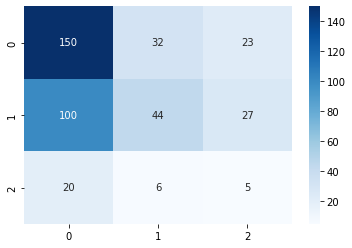

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm1 = confusion_matrix(df.y_pred_oligo, df_compare.oligo_state)
sns.heatmap(cm1, annot=True, cmap="Blues", fmt="d")
#accuracy
cm1.diagonal().sum()/cm1.sum()

# cm2 = confusion_matrix(df.y_pred_parallel, tdf.parallel)
# sns.heatmap(cm2, annot=True, cmap="Blues", fmt="d")

In [69]:
ddf = pd.read_csv('tests/set4_homooligomers.csv', sep = "\t")
# calculate average length of full sequence
ddf['full_sequence_len'] = ddf.full_sequence.apply(lambda x: len(x))
ddf.full_sequence_len.mean()
ddf.full_sequence_len.median()
ddf.full_sequence_len.max()

221